In [3]:
import numpy as np
import pandas as pd
from copy import deepcopy as dc

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('AMZN.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [6]:
df = df.drop(columns=['Open', 'Adj Close'])  # Rimuove le colonne indesiderate

# Riordina le colonne mettendo 'Close' subito dopo 'Date'
cols = ['Date', 'Close'] + [col for col in df.columns if col not in ['Date', 'Close']]
df = df[cols]

df

,Date,Close,High,Low,Volume
0,1997-05-15,0.097917,0.125000,0.096354,1443120000
1,1997-05-16,0.086458,0.098958,0.085417,294000000
2,1997-05-19,0.085417,0.088542,0.081250,122136000
3,1997-05-20,0.081771,0.087500,0.081771,109344000
4,1997-05-21,0.071354,0.082292,0.068750,377064000
...,...,...,...,...,...
6511,2023-03-30,102.000000,103.040001,101.010002,53633400
6512,2023-03-31,103.290001,103.489998,101.949997,56704300
6513,2023-04-03,102.410004,103.290001,101.430000,41135700
6514,2023-04-04,103.949997,104.199997,102.110001,48662500


In [7]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,Close,High,Low,Volume,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,,,,
1997-05-27,0.079167,0.082292,0.072917,173952000,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.081771,0.076563,91488000,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.077083,0.073958,69456000,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075521,0.073958,51888000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.076563,0.075000,11832000,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,103.040001,101.010002,53633400,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,103.489998,101.949997,56704300,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,101.430000,41135700,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [8]:
# Prepara lo scaler e scala i dati
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(shifted_df)
scaled_data

array([[4.46864078e-05, 4.14307962e-05, 2.25522717e-05, ...,
        8.37798446e-05, 8.93615930e-05, 1.50803720e-04],
       [3.07239161e-05, 3.86680361e-05, 4.22848329e-05, ...,
        6.42303205e-05, 8.37798446e-05, 8.93615930e-05],
       [2.37373083e-05, 1.38084978e-05, 2.81862806e-05, ...,
        8.37530351e-06, 6.42303205e-05, 8.37798446e-05],
       ...,
       [5.48736493e-01, 5.47331532e-01, 5.48578462e-01, ...,
        5.25307449e-01, 5.25789999e-01, 5.28899918e-01],
       [5.56993843e-01, 5.52157061e-01, 5.52258704e-01, ...,
        5.21017905e-01, 5.25307449e-01, 5.25789999e-01],
       [5.41712319e-01, 5.50619286e-01, 5.44898226e-01, ...,
        5.37157265e-01, 5.21017905e-01, 5.25307449e-01]])

In [9]:
scaled_data.shape

(6509, 11)


# 1. Creazione dati base

In [11]:
# Prepara X e y
X = scaled_data[:, 1:]  # Tutte le colonne tranne la prima (che è Close attuale)
y = scaled_data[:, 0]   # Prima colonna (Close attuale)

# Split train/test (80% train)
train_size = int(len(X) * 0.85)
X_train_base = X[:train_size]
X_test = X[train_size:]
y_train_base = y[:train_size]
y_test = y[train_size:]

print("Forma X_train:", X_train_base.shape)
print("Forma X_test:", X_test.shape)
print("Forma y_train:", y_train_base.shape)
print("Forma y_test:", y_test.shape)

Forma X_train: (5532, 10)
Forma X_test: (977, 10)
Forma y_train: (5532,)
Forma y_test: (977,)


# 2. Creazione dati con jittering

In [12]:
# Jittering dei dati
def apply_jittering(X, std=0.01, n_samples=1):
    jittered_data = []
    for _ in range(n_samples):
        noise = np.random.normal(0, std, X.shape)
        jittered_data.append(X + noise)
    return np.vstack([X] + jittered_data)

# Applica jittering
X_train_jitter = apply_jittering(X_train_base, std=0.01, n_samples=2)
y_train_jitter = np.tile(y_train_base, 3)

In [13]:
X_train_jitter.shape

(16596, 10)

# 3. Creazione dati con GAN

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np

# Generatore
def build_generator(latent_dim, n_features):
    model = tf.keras.Sequential([
        Dense(256, input_shape=(latent_dim,)),  # Aumentato a 256 per gestire più features
        Dense(128, activation='relu'),          # Aggiunto layer intermedio
        Dense(64, activation='relu'),
        Dense(n_features, activation='tanh')    # Ora output 10 features
    ])
    return model

# Discriminatore
def build_discriminator(n_features):
    model = tf.keras.Sequential([
        Dense(128, input_shape=(n_features,)),  # Aumentato a 128 per gestire più features
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),           # Aggiunto layer intermedio
        Dense(1, activation='sigmoid')
    ])
    return model

# Training GAN
latent_dim = 100  # Aumentato per maggiore varietà
generator = build_generator(latent_dim, 10)     # 10 features
discriminator = build_discriminator(10)

discriminator.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
discriminator.trainable = False

gan = tf.keras.Sequential([generator, discriminator])
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training loop con monitoraggio delle performance
batch_size = 64  # Aumentato per maggiore stabilità
n_epochs = 100

for epoch in range(n_epochs):
    # Training discriminator
    idx = np.random.randint(0, X_train_base.shape[0], batch_size)
    real_data = X_train_base[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_data = generator.predict(noise)

    # Training con dati reali e fake
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Training generator
    noise = np.random.normal(0, 1, (batch_size * 2, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size * 2, 1)))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]:.4f}, G Loss: {g_loss:.4f}")

# Genera dati sintetici
n_synthetic = X_train_base.shape[0]
noise = np.random.normal(0, 1, (n_synthetic, latent_dim))
X_train_gan = np.vstack([X_train_base, generator.predict(noise)])
y_train_gan = np.tile(y_train_base, 2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss: 0.6831, D Acc: 0.2422, G Loss: 0.7855
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 10, D Loss: 0.6920, D Acc: 0.2890, G Loss: 0.7108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 20, D Loss: 0.7056, D Acc: 0.1563, G Loss: 0.6842
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/st

In [17]:
X_train_gan.shape

(11064, 10)

# 4. Creazione e training dei modelli

In [19]:
def create_model(n_features):
    inputs = Input(shape=(n_features,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Crea e addestra i tre modelli
model_base = create_model(10)
model_jitter = create_model(10)
model_gan = create_model(10)

# Training
history_base = model_base.fit(X_train_base, y_train_base,
                            epochs=50, batch_size=32, validation_split=0.1, verbose=1)

history_jitter = model_jitter.fit(X_train_jitter, y_train_jitter,
                                epochs=50, batch_size=32, validation_split=0.1, verbose=1)

history_gan = model_gan.fit(X_train_gan, y_train_gan,
                          epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.7159e-04 - val_loss: 2.2892e-04
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8471e-06 - val_loss: 2.1131e-04
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9622e-06 - val_loss: 2.2014e-04
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9629e-06 - val_loss: 1.5488e-04
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0172e-06 - val_loss: 1.6276e-04
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3846e-06 - val_loss: 1.1394e-04
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8385e-06 - val_loss: 9.9467e-05
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4751e-06 - val_loss: 1.0142e-04
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9984e-06 - val_loss: 8.8087e-05
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6669e-06 - val_loss: 8.9322e-05
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - los

# 5. Valutazione e confronto

In [20]:
# Predizioni
y_pred_base = model_base.predict(X_test)
y_pred_jitter = model_jitter.predict(X_test)
y_pred_gan = model_gan.predict(X_test)

# Inverse transform per le predizioni
# Creiamo array temporanei con la stessa struttura dei dati originali
temp = np.zeros((len(y_test), scaled_data.shape[1]))
temp[:, 0] = y_test
y_test_real = scaler.inverse_transform(temp)[:, 0]

temp[:, 0] = y_pred_base.flatten()
y_pred_base_real = scaler.inverse_transform(temp)[:, 0]

temp[:, 0] = y_pred_jitter.flatten()
y_pred_jitter_real = scaler.inverse_transform(temp)[:, 0]

temp[:, 0] = y_pred_gan.flatten()
y_pred_gan_real = scaler.inverse_transform(temp)[:, 0]

# Calcolo metriche
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

metrics_base = calculate_metrics(y_test_real, y_pred_base_real)
metrics_jitter = calculate_metrics(y_test_real, y_pred_jitter_real)
metrics_gan = calculate_metrics(y_test_real, y_pred_gan_real)

# DataFrame con le metriche
metrics_df = pd.DataFrame({
    'Base Model': metrics_base,
    'Jittering Model': metrics_jitter,
    'GAN Model': metrics_gan
}, index=['RMSE', 'MAE', 'MAPE (%)'])

print("\nConfronto delle metriche:")
print(metrics_df)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Confronto delle metriche:
          Base Model  Jittering Model  GAN Model
RMSE        3.700593         1.968717   1.904829
MAE         3.013867         1.521449   1.594648
MAPE (%)    2.180669         1.160208   1.300128


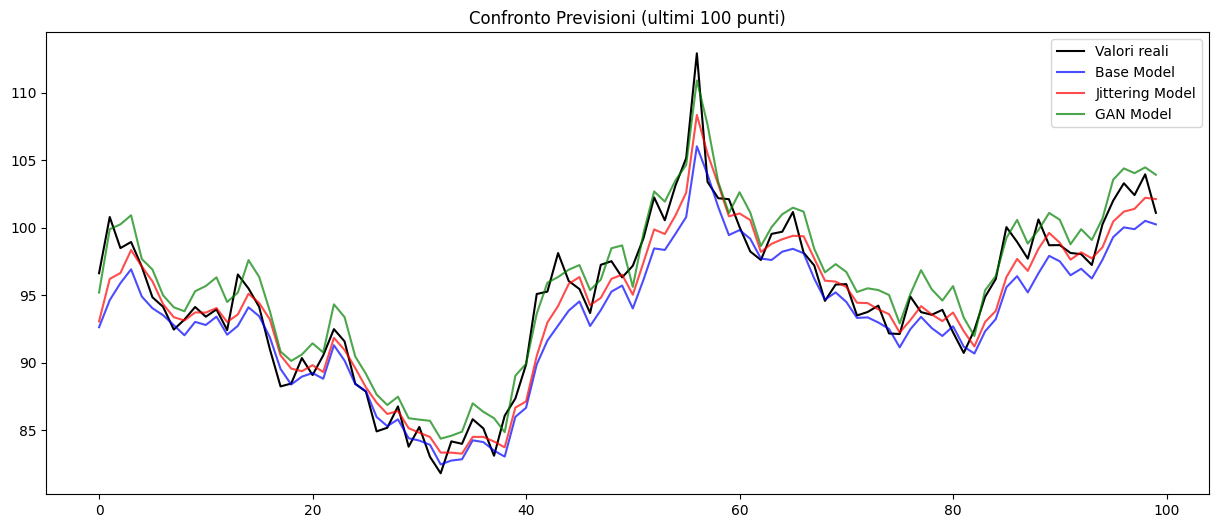

In [21]:
# Visualizzazione risultati
plt.figure(figsize=(15, 6))
plt.plot(y_test_real[-100:], label='Valori reali', color='black')
plt.plot(y_pred_base_real[-100:], label='Base Model', color='blue', alpha=0.7)
plt.plot(y_pred_jitter_real[-100:], label='Jittering Model', color='red', alpha=0.7)
plt.plot(y_pred_gan_real[-100:], label='GAN Model', color='green', alpha=0.7)
plt.title('Confronto Previsioni (ultimi 100 punti)')
plt.legend()
plt.show()

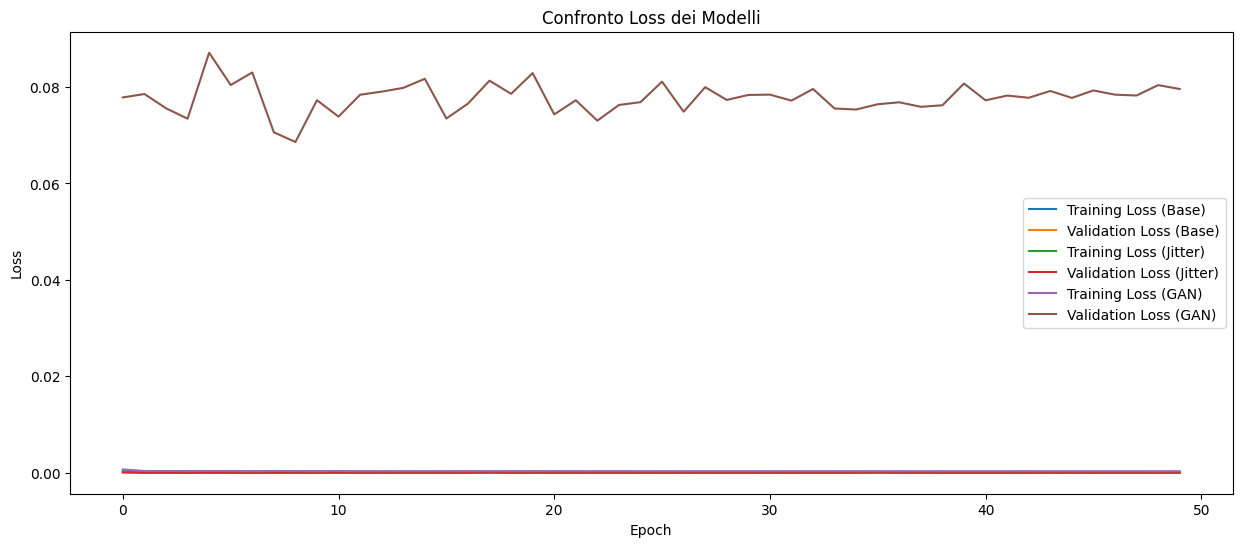

In [22]:
# Confronto delle loss
plt.figure(figsize=(15, 6))
plt.plot(history_base.history['loss'], label='Training Loss (Base)')
plt.plot(history_base.history['val_loss'], label='Validation Loss (Base)')
plt.plot(history_jitter.history['loss'], label='Training Loss (Jitter)')
plt.plot(history_jitter.history['val_loss'], label='Validation Loss (Jitter)')
plt.plot(history_gan.history['loss'], label='Training Loss (GAN)')
plt.plot(history_gan.history['val_loss'], label='Validation Loss (GAN)')
plt.title('Confronto Loss dei Modelli')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()